In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from nltk.tokenize import RegexpTokenizer
import nltk
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix 
from imblearn.combine import SMOTETomek
from PIL import Image 
from wordcloud import WordCloud
import time
# nltk.download('stopwords')



In [2]:
df = pd.read_csv('job_train.csv')

In [3]:
df.head()

,title,location,description,requirements,telecommuting,has_company_logo,has_questions,fraudulent
0,Architect (Middleware - MQ) - Kuwait,"KW, KU,","On behalf of our client, a well known multinat...",-Working technical knowledge of IT systems and...,0,1,0,0
1,Interviewing Now for Sales Rep Positions -- wi...,"US, TX, Corpus Christi","We are Argenta Field Solutions, a rapidly expa...",#NAME?,0,1,0,0
2,Process Controls Staff Engineer - Foxboro I/A ...,"US, TX, USA Southwest",Experienced Process Controls Staff Engineer is...,At least 10 years of degreed professional expe...,0,0,0,0
3,Experienced Telemarketer Wanted - Digital Solu...,"AU, NSW,",If you have a passion for people and love to s...,"Responsibilities - Prospecting, following up a...",0,1,0,0
4,Senior Network Engineer,"GB, ENG, London",As the successful Senior Network Engineer you ...,Essential skills:•Juniper switching/routing/se...,0,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8940 entries, 0 to 8939
Data columns (total 8 columns):
title               8940 non-null object
location            8783 non-null object
description         8939 non-null object
requirements        7614 non-null object
telecommuting       8940 non-null int64
has_company_logo    8940 non-null int64
has_questions       8940 non-null int64
fraudulent          8940 non-null int64
dtypes: int64(4), object(4)
memory usage: 558.9+ KB


In [5]:
df.shape

(8940, 8)

In [6]:
df.isnull().sum()

title                  0
location             157
description            1
requirements        1326
telecommuting          0
has_company_logo       0
has_questions          0
fraudulent             0
dtype: int64

In [7]:
df.nunique()

title               6132
location            2131
description         7767
requirements        6327
telecommuting          2
has_company_logo       2
has_questions          2
fraudulent             2
dtype: int64

,fraudulent,title
0,0,8484
1,1,456


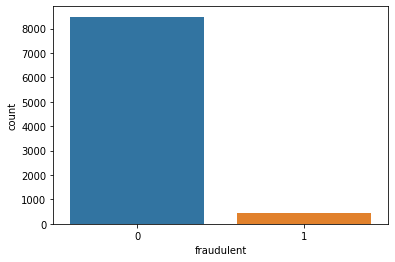

In [8]:
sns.countplot(df.fraudulent)
df.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

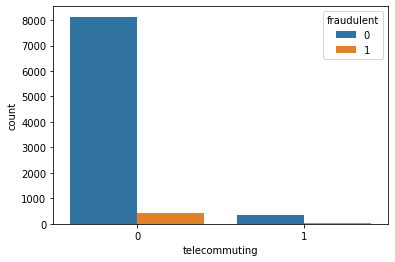

In [9]:
sns.countplot(x='telecommuting',data=df,hue='fraudulent');

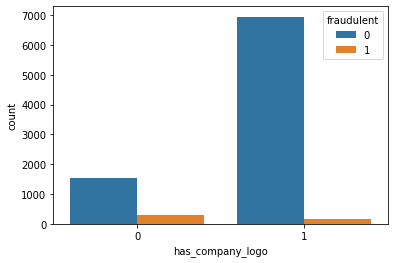

In [10]:
sns.countplot(x='has_company_logo',data=df,hue='fraudulent');

In [11]:
df['description'] = df['description'] + ' ' + df['requirements'] + ' ' + df['title']

In [12]:
df.drop(['title', 'requirements','location'], axis = 1, inplace = True)
df = df.replace(np.nan, '', regex=True)

In [13]:
df.head()

,description,telecommuting,has_company_logo,has_questions,fraudulent
0,"On behalf of our client, a well known multinat...",0,1,0,0
1,"We are Argenta Field Solutions, a rapidly expa...",0,1,0,0
2,Experienced Process Controls Staff Engineer is...,0,0,0,0
3,If you have a passion for people and love to s...,0,1,0,0
4,As the successful Senior Network Engineer you ...,0,1,0,0


In [14]:
t0= time.clock()
stop_words = set(stopwords.words("english"))
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_tokenizer=RegexpTokenizer(r"\w+")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [15]:
def clean_text(text, ):
        if text is not None:
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
                text = re.sub(r'[0-9]+','',text)
                text =  text.lower()
                text = re.sub('re:', '', text)
                text = re.sub('-', '', text)
                text = re.sub('_', '', text)
                text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
                text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE)
        # Remove text between square brackets
                text =re.sub('\[[^]]*\]', '', text)
        # removes punctuation
                text = re.sub(r'[^\w\s]','',text)
                text = re.sub(r'\n',' ',text)
                text = re.sub(r'[0-9]+','',text)
                #text = re.sub(r'[0-9]+','',text)
        # strip html 
                p = re.compile(r'<.*?>')
                text = re.sub(r"\'ve", " have ", text)
                text = re.sub(r"can't", "cannot ", text)
                text = re.sub(r"n't", " not ", text)
                text = re.sub(r"I'm", "I am", text)
                text = re.sub(r" m ", " am ", text)
                text = re.sub(r"\'re", " are ", text)
                text = re.sub(r"\'d", " would ", text)
                text = re.sub(r"\'ll", " will ", text)
        
                text = p.sub('', text)

        def tokenize_text(text,tokenizer=default_tokenizer):
            token = default_tokenizer.tokenize(text)
            return token
        
        def remove_stopwords(text, stop_words=default_stopwords):
            tokens = [w for w in tokenize_text(text) if w not in stop_words]
            return ' '.join(tokens)

        def stem_text(text, stemmer=default_stemmer):
            tokens = tokenize_text(text)
            return ' '.join([stemmer.stem(t) for t in tokens])

        text = stem_text(text) # stemming
        text = remove_stopwords(text) # remove stopwords
        #text.strip(' ') # strip whitespaces again?

        return text

In [16]:
df['description'] = df['description'].apply(clean_text)
t_cleaning = time.clock() - t0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [17]:
df['description'].head()

0    behalf client well known multin retail compani...
1    argenta field solut rapidli expand award win f...
2    experienc process control staff engin requir r...
3    passion peopl love sell telephon thi role over...
4    success senior network engin must jncia certif...
Name: description, dtype: object

In [18]:
bgy=np.array(Image.open("wordcloud_masks/yoda.png"))

wc1=WordCloud(background_color = "white",mask=bgy,max_words=300)
wc0=WordCloud(background_color = "white",max_words=300)


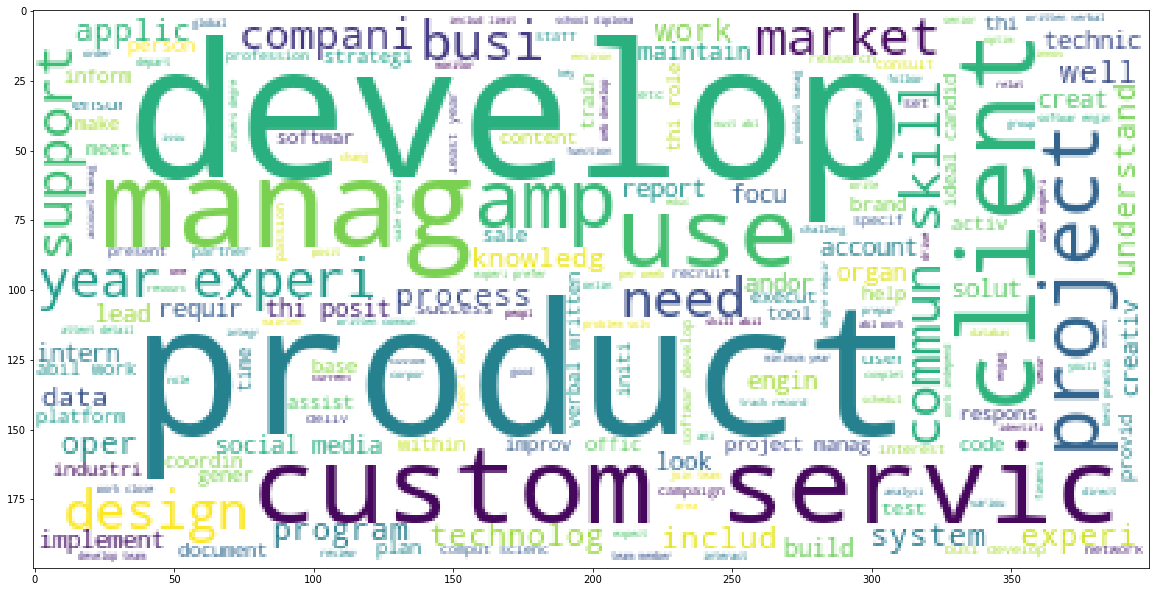

In [19]:
wc0.generate(" ".join(df[df.fraudulent == 0]['description']))

plt.figure(figsize=(20,15))
plt.imshow(wc0)

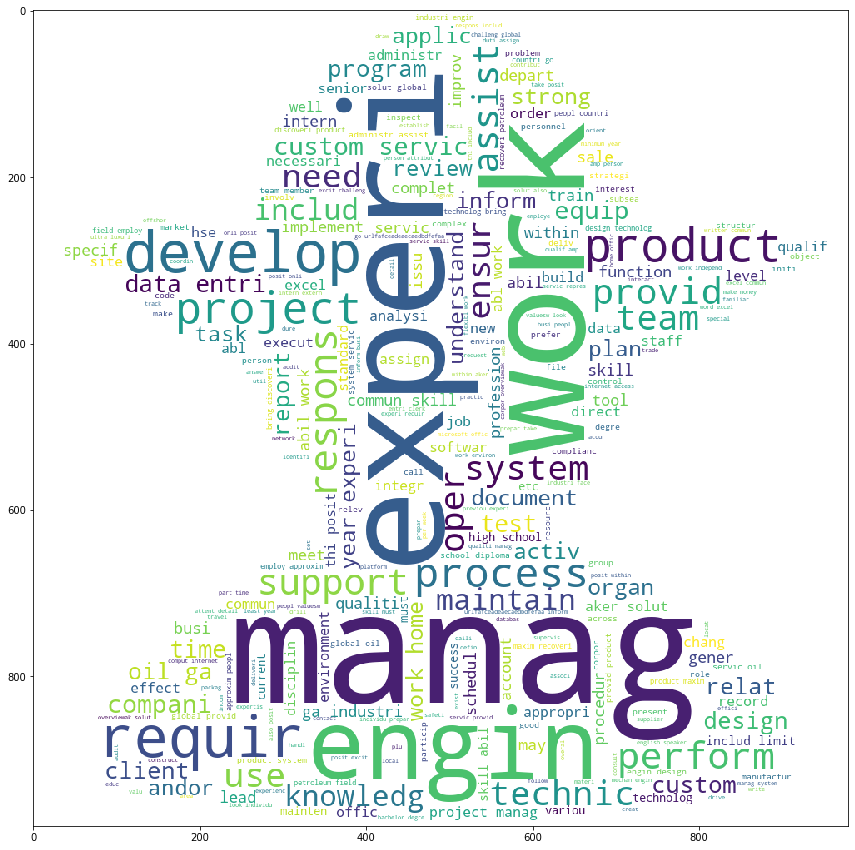

In [20]:
wc1.generate(" ".join(df[df.fraudulent == 1]['description']))

plt.figure(figsize=(20,15))
plt.imshow(wc1)

In [21]:
t0 = time.clock()
cv = TfidfVectorizer(max_features = 100)
x = cv.fit_transform(df['description'])
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names())
df.drop(["description"], axis=1, inplace=True)
main_df = pd.concat([df1,df], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [22]:
main_df.head()

,abil,abl,account,activ,amp,applic,assist,base,build,busi,...,web,well,within,work,written,year,telecommuting,has_company_logo,has_questions,fraudulent
0,0.069288,0.080178,0.0,0.000000,0.000000,0.230955,0.000000,0.078295,0.000000,0.000000,...,0.259544,0.079061,0.000000,0.045118,0.079647,0.055662,0,1,0,0
1,0.000000,0.000000,0.0,0.000000,0.116732,0.000000,0.135833,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.083537,0,1,0,0
2,0.000000,0.140450,0.0,0.000000,0.000000,0.168572,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.039518,0.000000,0.073129,0,0,0,0
3,0.000000,0.000000,0.0,0.115042,0.000000,0.000000,0.000000,0.000000,0.096825,0.082017,...,0.000000,0.000000,0.000000,0.116105,0.102480,0.000000,0,1,0,0
4,0.000000,0.000000,0.0,0.000000,0.115263,0.000000,0.000000,0.000000,0.000000,0.094462,...,0.000000,0.000000,0.123671,0.267444,0.000000,0.000000,0,1,0,0


In [23]:
Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

In [ ]:
smk  = SMOTETomek(random_state=42)
X_res,Y_res= smk.fit_sample(X,Y)

In [ ]:
Y_res.value_counts().plot(kind="bar" ,color=['blue','orange'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res,Y_res, test_size=0.25, random_state=42)
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model=rfc.fit(X_train,y_train)

In [ ]:
rfc.score(X_train,y_train)

In [ ]:
rfc.score(X_test,y_test)

In [ ]:
rfc_predict = rfc.predict(X_test)

In [ ]:
print(classification_report(y_test, rfc_predict))

In [ ]:
confusion_matrix(y_test, rfc_predict)

In [ ]:

from sklearn.metrics import precision_score,recall_score, accuracy_score, f1_score

In [ ]:
print( 'Accuracy:', accuracy_score(y_test, rfc_predict))
print( 'F1 score::', f1_score(y_test, rfc_predict))

print( 'Recall:', recall_score(y_test, rfc_predict))
print ('Precision:', precision_score(y_test, rfc_predict))

In [ ]:
t_model = time.clock() - t0
totaltime=t_model+t_cleaning
print('Total Time ',totaltime)